<h1 style="text-align:center">ModelBuilder and Python: Two Peas in a Pod</h1>

<p style="font-size:24px; text-align:center">
Ohio GIS Conference Workshop<br />
September 22, 2020<br />
</p>

<p style="text-align:center">
    <a href="mailto:porr.4@osu.edu">Adam Porr</a><br />
    Consulting Manager<br />
    <a href="https://cura.osu.edu">Center for Urban and Regional Analysis</a>
</p>

## Abstract

When it comes to developing geoprocessing pipelines, [ArcGIS ModelBuilder](https://desktop.arcgis.com/en/arcmap/latest/analyze/modelbuilder/what-is-modelbuilder.htm) and [Python](https://www.python.org/) are a combination that can't be beat! In this workshop we will describe how to build a geoprocessing pipeline that leverages the flexibility of Python and its [panoply of packages](https://pypi.org/) while retaining the simple and familiar ModelBuilder user interface. As an example, we'll walk through a hybrid model/script that downloads U.S. Census data via the [Census API](https://www.census.gov/data/developers.html), performs some simple manipulations of the data, joins it to geography polygons (also automatically downloaded from the Census website), creates a map, and publishes via [ArcGIS Online](https://www.arcgis.com/). Attendees will learn about the complementary strengths and weaknesses of Python and ModelBuilder, how to use Python to fetch U.S. Census data and prepare it for use in ArcGIS, and how to incorporate Python code in a ModelBuilder model as a script tool. Attendees should have some familiarity with ModelBuilder. Familiarity with Python is helpful, but not required.

## Agenda

  1. Why ModelBuilder + Python?
  2. An example ModelBuilder + Python use case
  3. Anatomy of a Python script
  4. Preparing the script for ModelBuilder
  5. Integrating the script with ModelBuilder
  6. Running the rest of the model
  7. Check out the final product!
  8. Closing thoughts and questions

(Ask questions anytime via the chat!)

## Accessing the content from this presentation

All of the content presented today is publicly available in GitLab:

https://gitlab.com/osucura/modelbuilder-and-python-two-peas-in-a-pod

The slides are available directly from the following URL:

https://osucura.gitlab.io/modelbuilder-and-python-two-peas-in-a-pod

# Why ModelBuilder + Python?

## The case for automation(?)

![Is it worth the time](https://imgs.xkcd.com/comics/automation.png)

Image credit: Randall Monroe ([XKCD](https://xkcd.com/1319/))

## The case for automation(?)

![Is it worth the time](https://imgs.xkcd.com/comics/is_it_worth_the_time.png)

Image credit: Randall Monroe ([XKCD](https://xkcd.com/1205/))

## The case for automation

Yes, **sometimes**, efficiency for recurring tasks!  

But also:

  - Reproducibility
  - Error reduction
  - Version control
  - Transferrability

## ModelBuilder vs Python

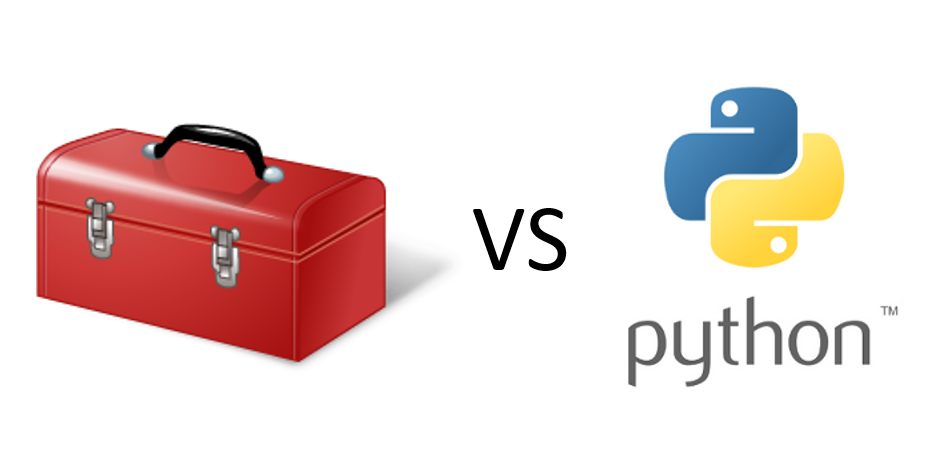

### ModelBuilder advantages

  - Simple
  - Visual
  - Minimal syntax
  - Built-in validation
  - Low learning curve (for ArcGIS users)
    

### Python advantages

  - Data handling
  - Loops and conditionals
  - Free
  - Fast
  - Stable
  - Text-based
    

## Why not both? (An intro to script tools)

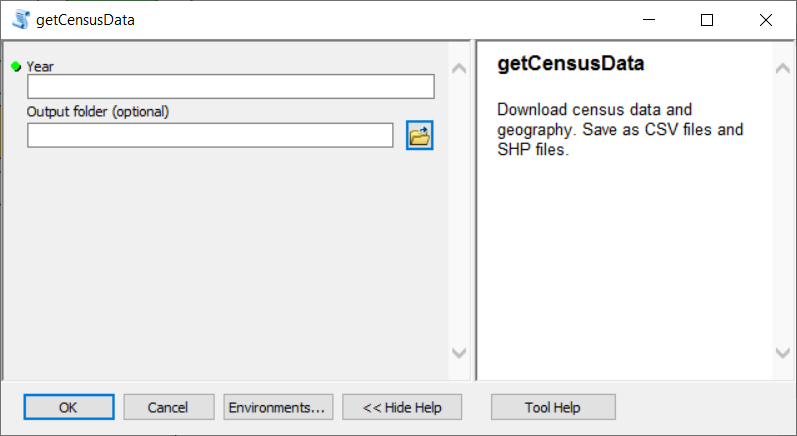

# An example ModelBuilder + Python use case

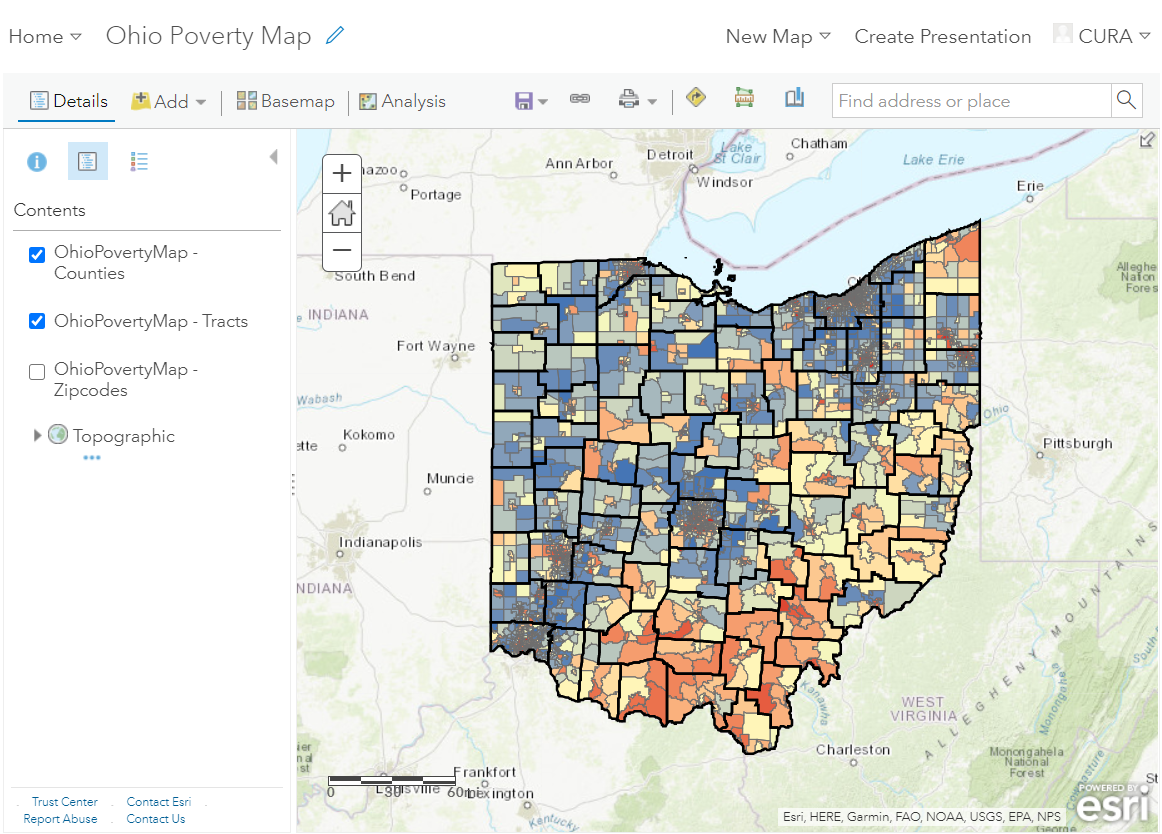

## Problem statement

Create an **interactive webmap** showing **poverty rates for Ohio zipcodes and census tracts**.  Prepare a **workflow for annual updates** that requires **minimal effort, skill, and licensing cost**.

## Requirements

  - Use only functionality provided by: 
    - ArcGIS Desktop Basic license
    - ArcGIS Online Creator license
  - Update process is fully automated
  - Update process can be triggered using ArcGIS geoprocessing tool interface
  - No Python knowledge required
  - Change to styling can be accomplished using ArcGIS in interactive (manual) mode

# Solution overview

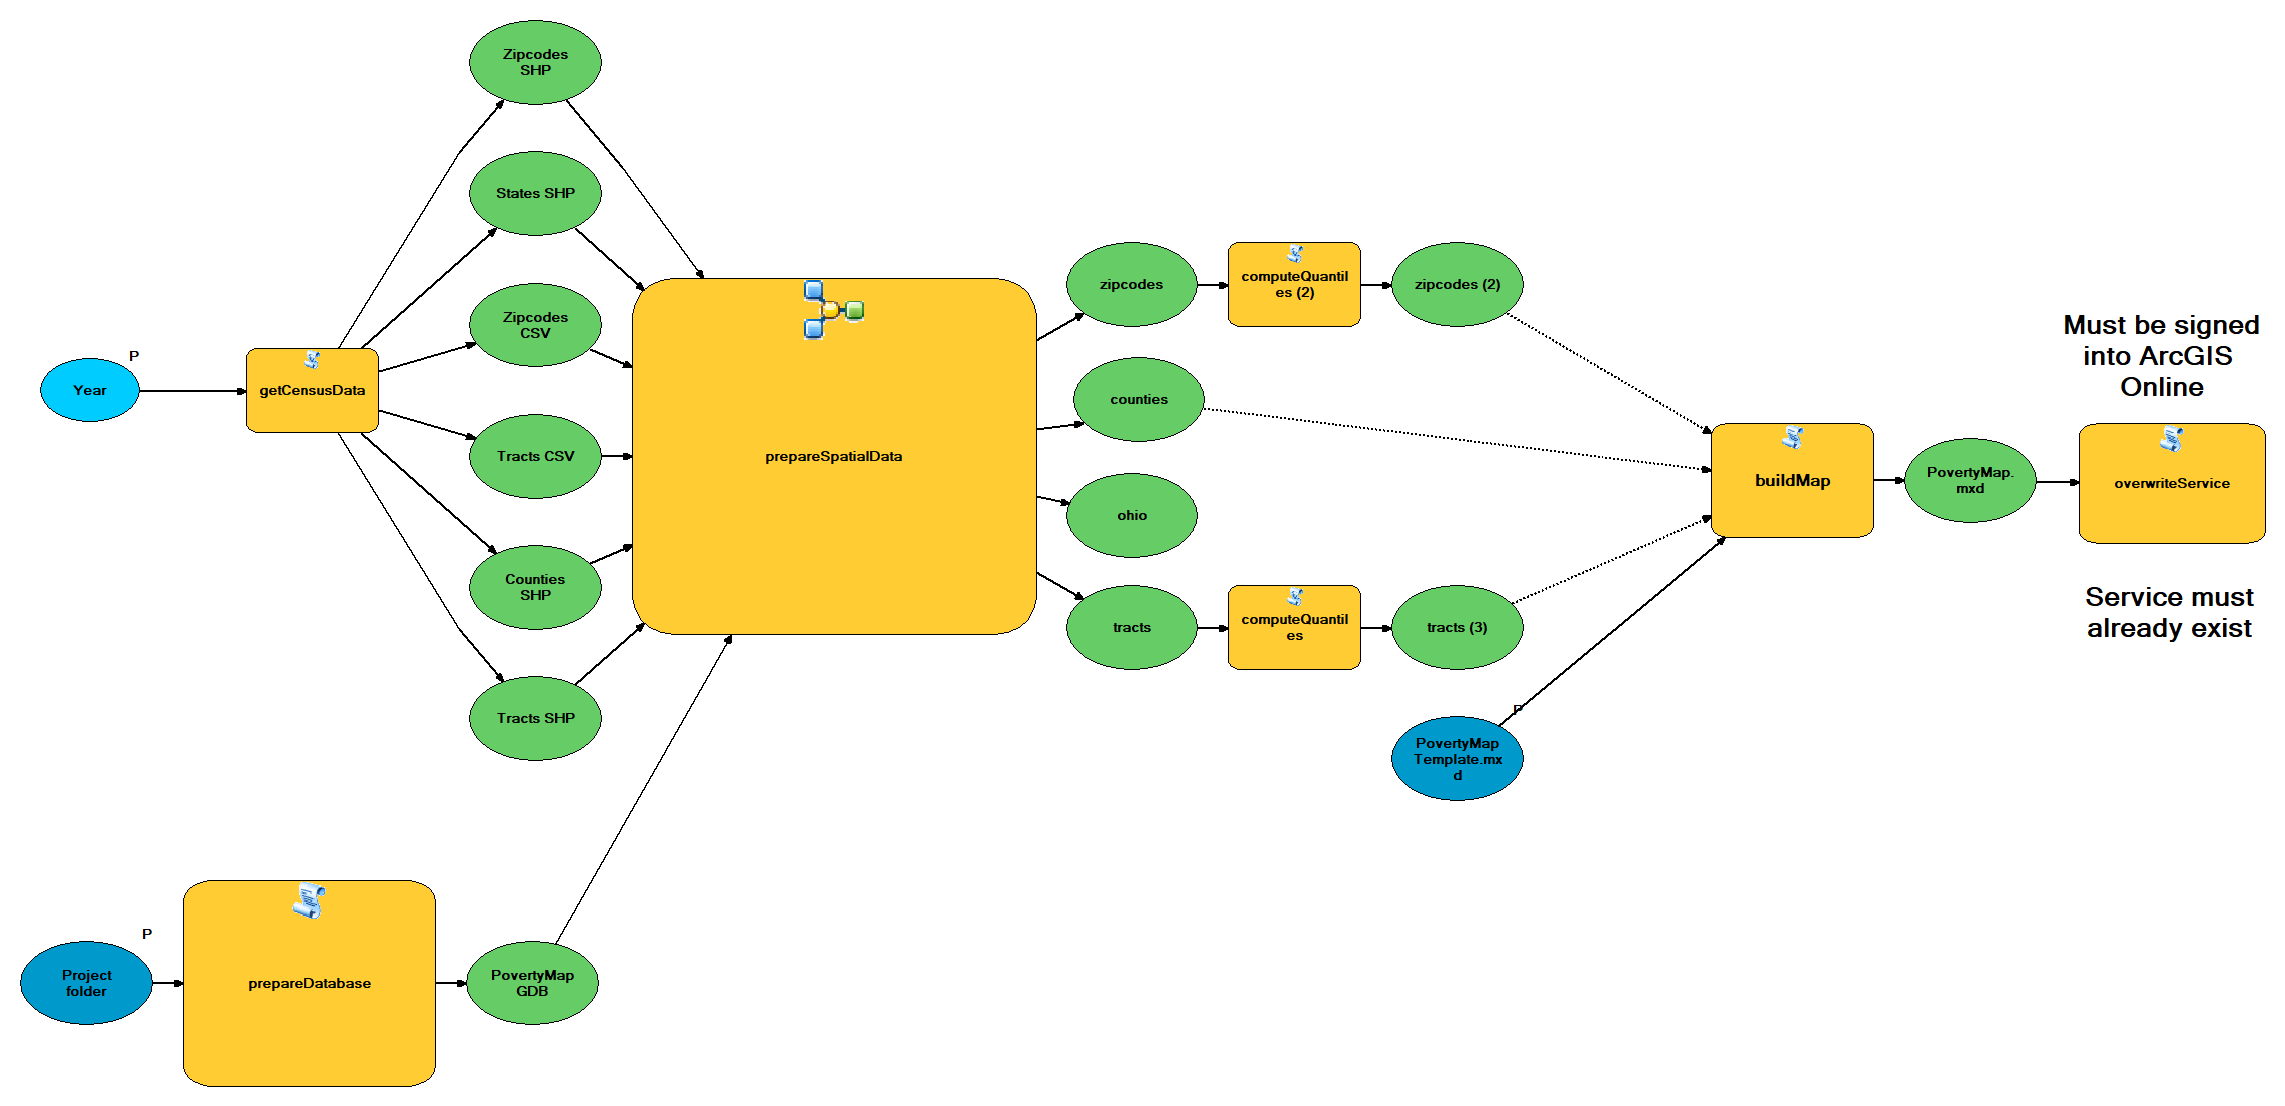

## Step 1: Fetch data (Python + pandas)

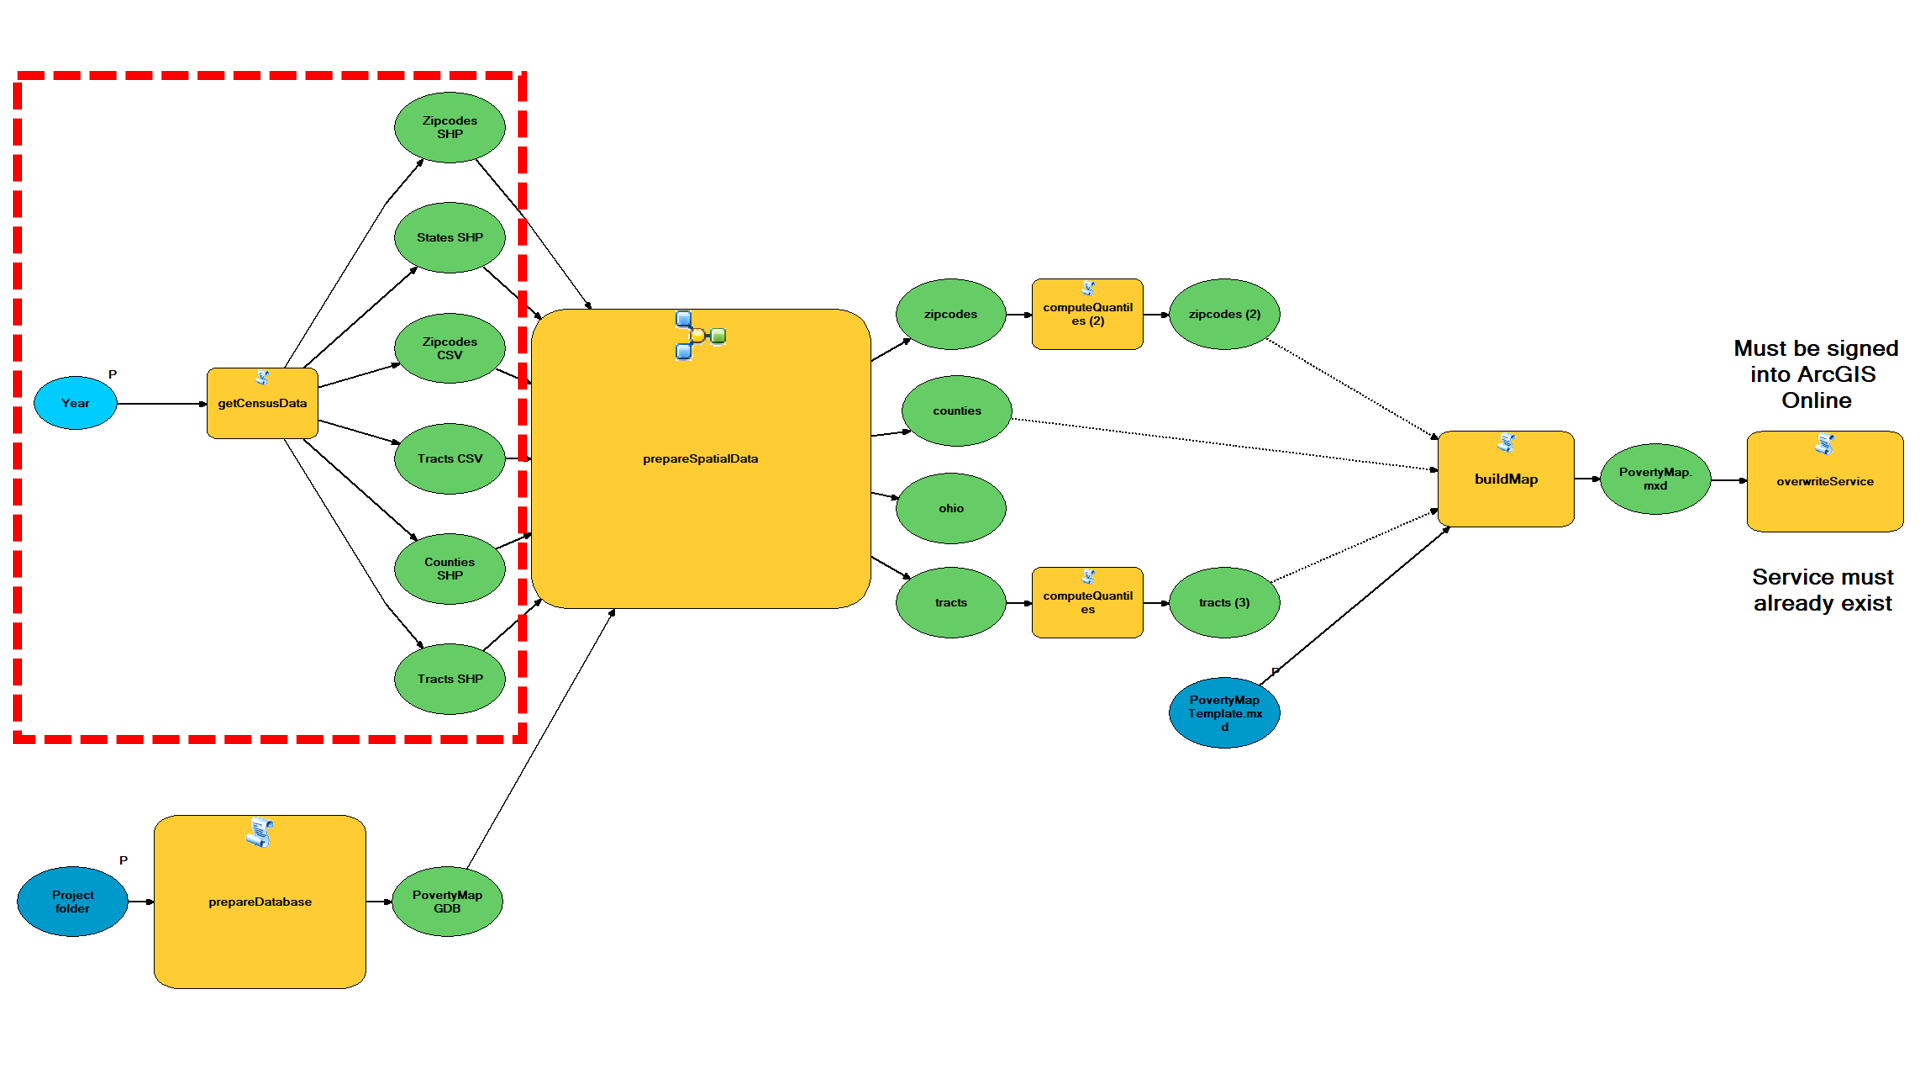

## Step 2: Process data (ModelBuilder)

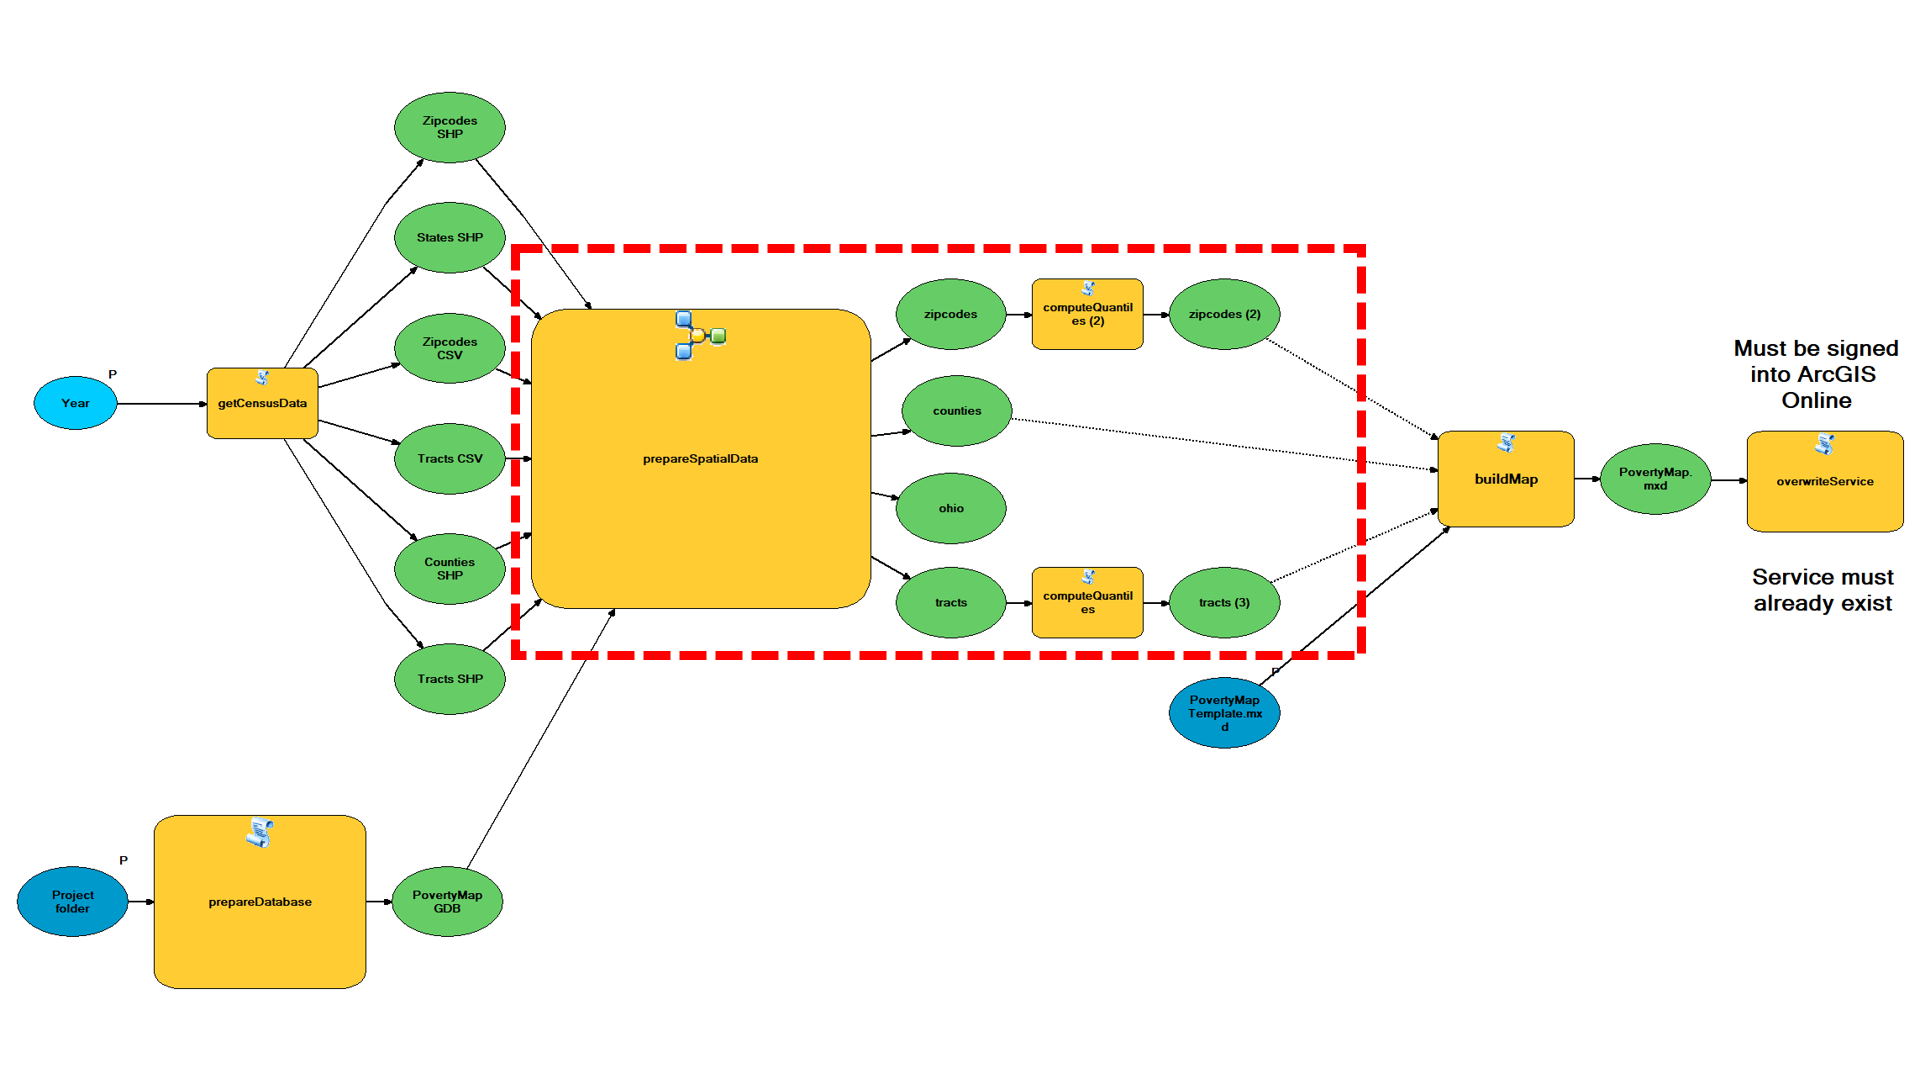

## Step 3: Create map (Python + arcpy)

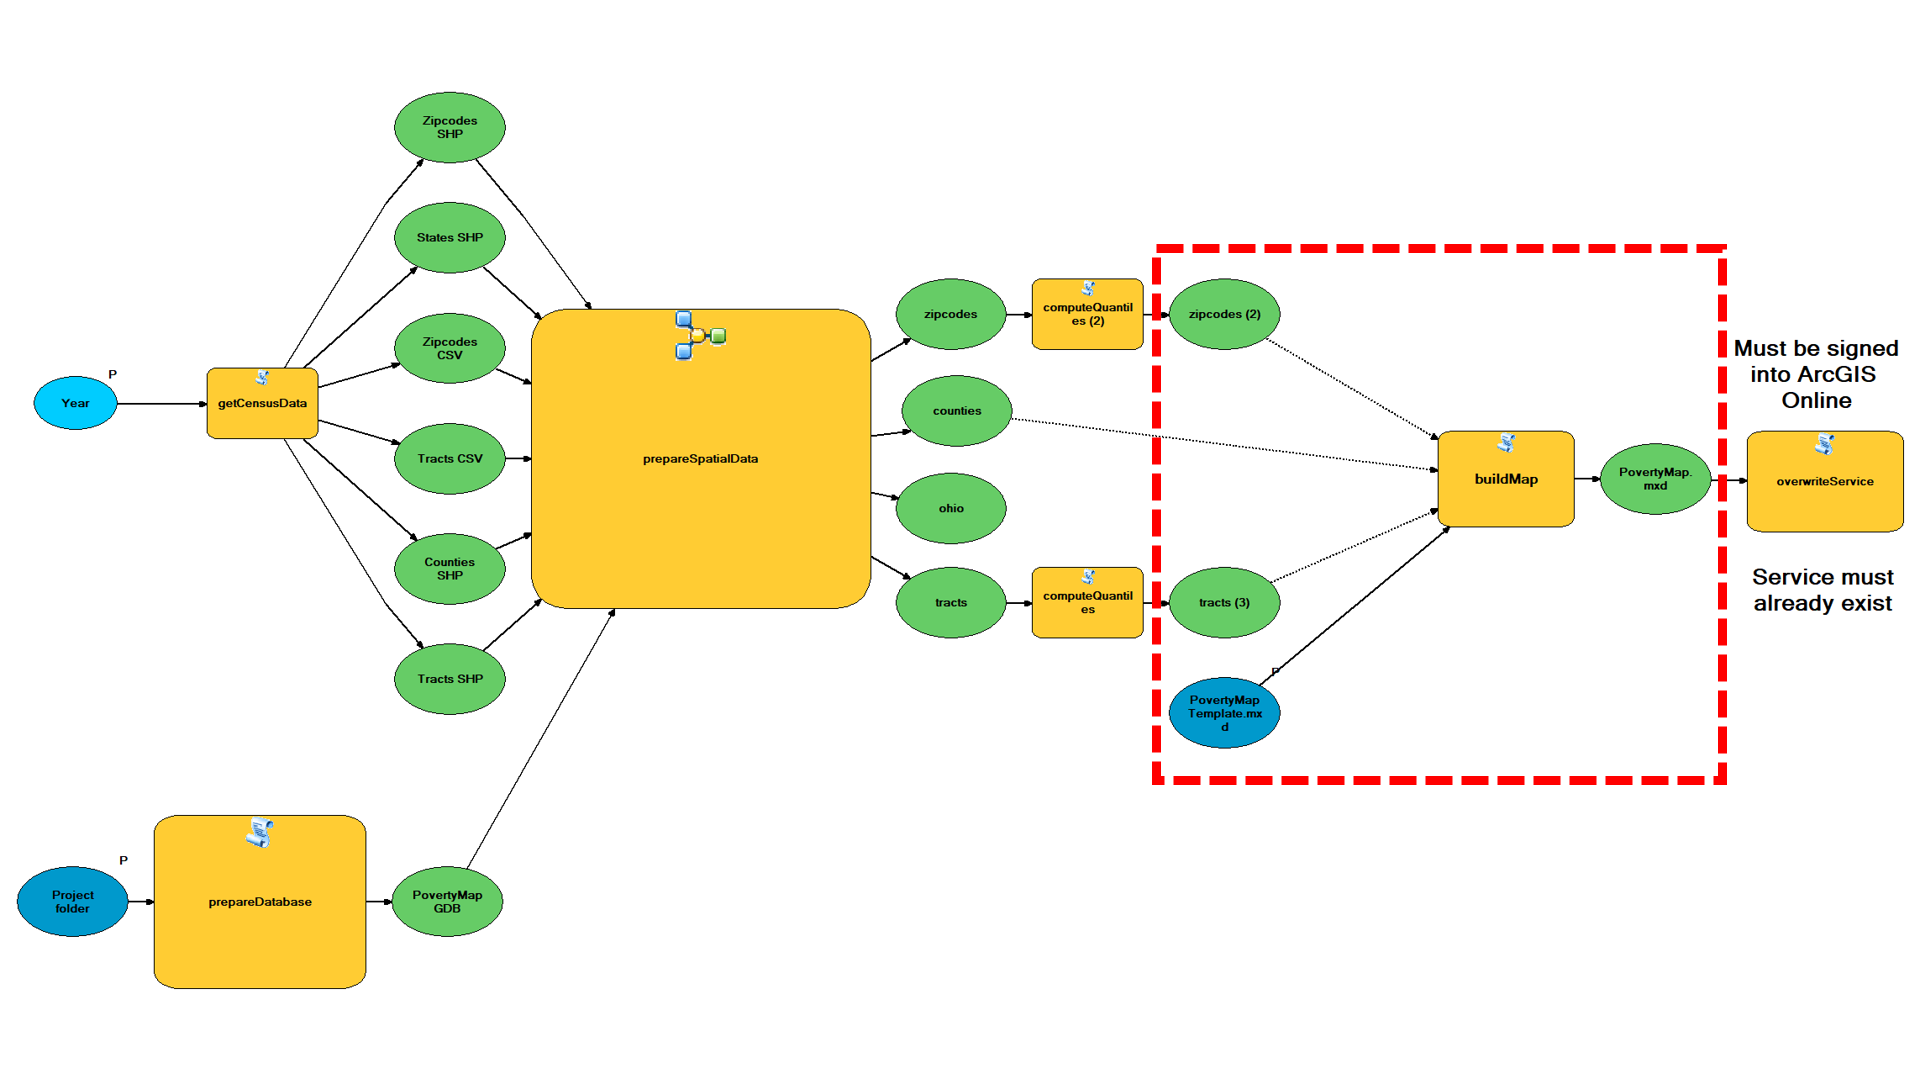

## Step 4: Publish web service (Python + arcpy)

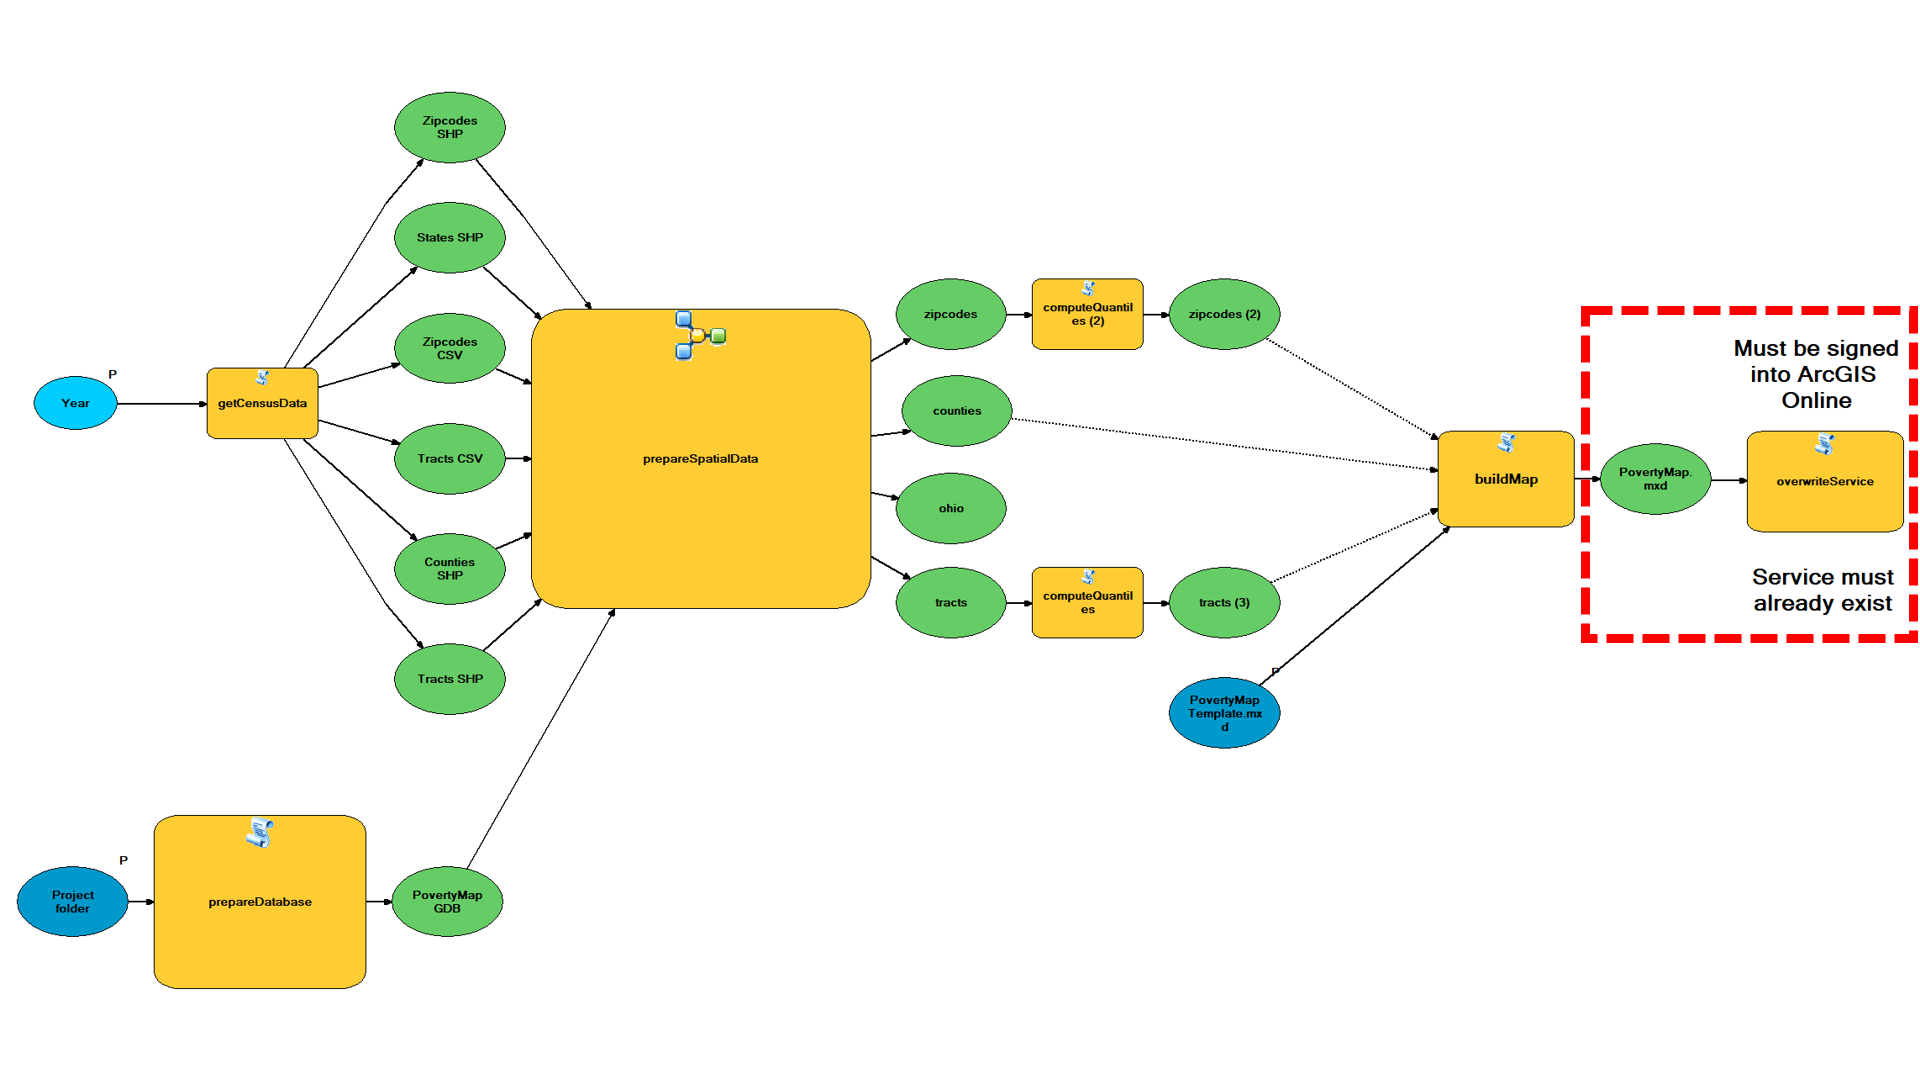

# Anatomy of a Python script

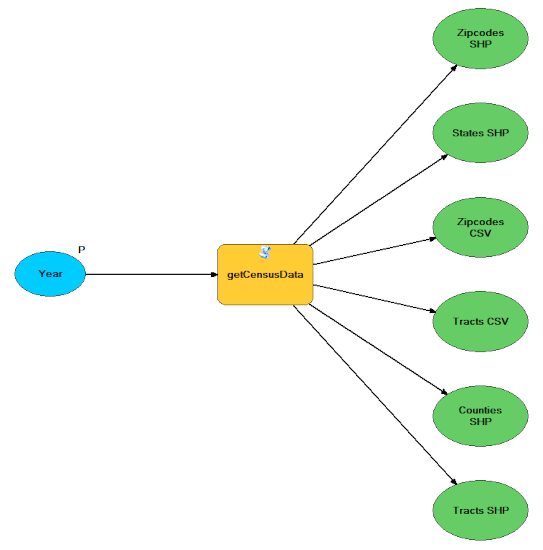

## Initialize some variables

In [ ]:
# Default path for all files created by script (can be overridden by input parameter)
DEFAULT_OUTPUT_FOLDER = os.path.normpath("./data")

# List of census variables to download:
#    NAME (Description of geography)
#    GEO_ID (Unique identifier for the geography)
#   S1701_C01_001E (Total population) for whom poverty status is determined
#   S1701_C02_001E (Below poverty level)
#   S1701_C03_001E (Percent below poverty level)
ACS_VARIABLES = ["NAME","GEO_ID","S0101_C01_001E","S1701_C02_001E","S1701_C03_001E"]

COLUMNS = ["NAME","GEO_ID","TOTAL","POVERTY","POVERTY_PCT"]

## Get user-specified parameters

In [ ]:
try: 
    year = os.path.normpath(sys.argv[1])
except IndexError:
    print("Data year is undefined.")
    sys.exit(-1)

try:
    outputFolder = os.path.normpath(sys.argv[2])
except IndexError:
    outputFolder = ""

# Prepare to retrieve data from Census API and static files

In [ ]:
boundariesSeq = ["zipcodes", "tracts", "states", "counties"]
boundariesUrl = {
    "zipcodes":"https://www2.census.gov/geo/tiger/GENZ{0}/shp/cb_{0}_us_zcta510_500k.zip".format(year),
    "tracts": "https://www2.census.gov/geo/tiger/GENZ{0}/shp/cb_{0}_39_tract_500k.zip".format(year),
    "states": "https://www2.census.gov/geo/tiger/GENZ{0}/shp/cb_{0}_us_state_500k.zip".format(year),
    "counties": "https://www2.census.gov/geo/tiger/GENZ{0}/shp/cb_{0}_us_county_500k.zip".format(year)
}

dataSeq = ["zipcodes", "tracts"]
dataUrl = {
    "zipcodes": "https://api.census.gov/data/{0}/acs/acs5/subject?get={1}&for=zip%20code%20tabulation%20area:*".format(year, ",".join(ACS_VARIABLES)),
    "tracts": "https://api.census.gov/data/{0}/acs/acs5/subject?get={1}&for=tract:*&in=state:39".format(year, ",".join(ACS_VARIABLES))
}

## Retrieve the spatial data

In [ ]:
for dataset in boundariesSeq:
    saveFile = os.path.join(outputFolder, year, dataset + "_shp.zip")
    if (os.path.exists(saveFile)):
        print(dataset.capitalize() + " shapefile already exists for this year.  Skipping download.")
    else:
        print("Downloading shapefile for " + dataset + ". (This might take a while)")
        try:
            urllib.urlretrieve(boundariesUrl[dataset], saveFile)
        except Exception as e:
            print(e)
            print("Failed to download shapefile for " + dataset)
            sys.exit(-1)
            
    zipOutputFolder = os.path.join(outputFolder, year, dataset + "_shp")
    if (os.path.exists(zipOutputFolder)):
        print("Deleting previously extracted data for " + dataset)    
        try:
            shutil.rmtree(zipOutputFolder)
        except:
            print("Failed to remove zip folder for " + dataset)
            sys.exit(-1)        

# OMITTED:  Unzip data to output folder

# Retrieve the attribute data

In [ ]:
for dataset in dataSeq:
    saveFile = os.path.join(outputFolder, year, dataset + "_data.json")
    if (os.path.exists(saveFile)):
        print(dataset.capitalize() + " data already exists for this year.  Deleting it.")
        try:
            os.unlink(saveFile)
        except:
            print("Failed to delete existing data for " + dataset)
            sys.exit(-1)        

    print("Downloading data for " + dataset + ". (This might take a while)")
    try:
        urllib.urlretrieve(dataUrl[dataset], saveFile)
    except:
        print("Failed to download data for " + dataset)
        sys.exit(-1)

## Export attribute data as CSV

In [ ]:
    print("Converting data for " + dataset + " to CSV")
    try:
        with open(saveFile, "r") as f:
            dataStr = f.read()
        dataObj = json.loads(dataStr)
        df = pd.DataFrame(data=dataObj[1:], columns=dataObj[0])
        df.set_index("GEO_ID", inplace=True)
        df.to_csv(saveFile.replace(".json", ".csv"))
    except:
        print("Failed to convert data for " + dataset)
        sys.exit(-1)

## Let's try it!

```C:\Python27\ArcGIS10.7\python getCensusData.py <YEAR>```


# Preparing the script for ModelBuilder

  - Getting data into the script
  - Getting data out of the script
  - Communicating status  

# Preparing the script for ModelBuilder

  - Getting data into the script
    - [arcpy.GetParameterAsText](https://desktop.arcgis.com/en/arcmap/latest/analyze/arcpy-functions/getparameterastext.htm)
    - [arcpy.GetParameter](https://desktop.arcgis.com/en/arcmap/latest/analyze/arcpy-functions/getparameter.htm)

  - Getting data out of the script 
    - [arcpy.SetParameterAsText](https://desktop.arcgis.com/en/arcmap/latest/analyze/arcpy-functions/setparameterastext.htm)
    - [arcpy.SetParameter](https://desktop.arcgis.com/en/arcmap/latest/analyze/arcpy-functions/setparameter.htm)
  

  - Communicating status
    - [arcpy.AddMessage](https://desktop.arcgis.com/en/arcmap/latest/analyze/arcpy-functions/addmessage.htm)
    - [arcpy.AddWarning](https://desktop.arcgis.com/en/arcmap/latest/analyze/arcpy-functions/addwarning.htm)
    - [arcpy.AddError](https://desktop.arcgis.com/en/arcmap/latest/analyze/arcpy-functions/adderror.htm)

## But first two concepts you need to know

### Command line arguments:

`C:\Python27\ArcGIS10.7\python getCensusData.py <YEAR>`

### Tool parameters:

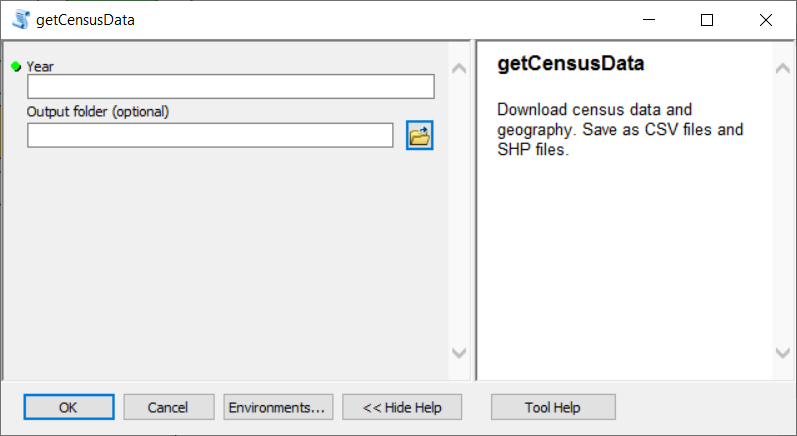


## Example: Getting data into the script


### Replace this:

`year = os.path.normpath(sys.argv[1])`

### with this:

`year = arcpy.GetParameterAsText(0).strip()`

*Note: `sys.argv[0]` is the Python executable itself*

## Example: Getting data out of the script


### Add this:

`arcpy.SetParameterAsText(3, saveFile.replace(".json", ".csv"))`

*Note: A simpler version might read as follows:*

`arcpy.SetParameterAsText(3, "outputFile.csv")`

## Example: Communicating status


### Replace this:

`print("Downloading data for " + dataset)`

### with this:

`arcpy.AddMessage("Downloading data for " + dataset)`

### or this:

`arcpy.AddWarning("You probably don't want to do that.")`

### or this!

`arcpy.AddError("Now look what you've done!")`

### This is how they appear in the ArcGIS geoprocessing output window

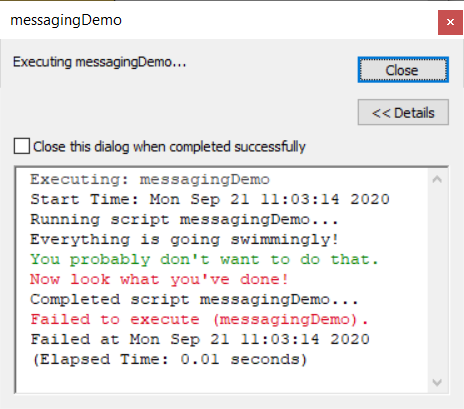

## Now let's do it for real!

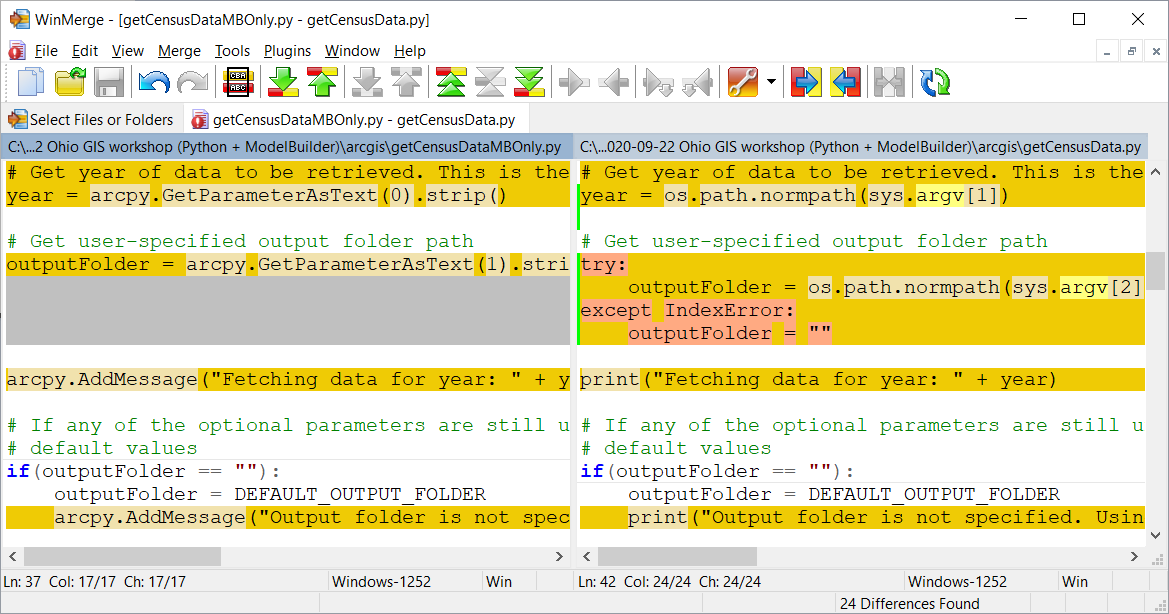

# Integrating the script with ModelBuilder

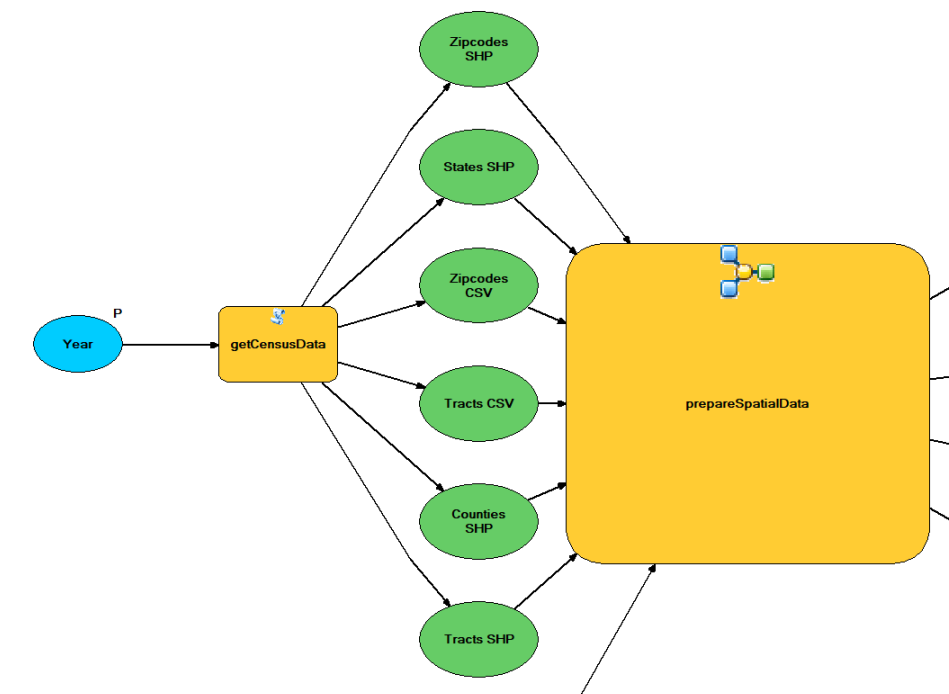

# Script integration process overview

  1. Create script tool "wrapper"
  2. Specify parameters
  3. Add tool to model
  4. Connect inputs and outputs

### Create script tool "wrapper"

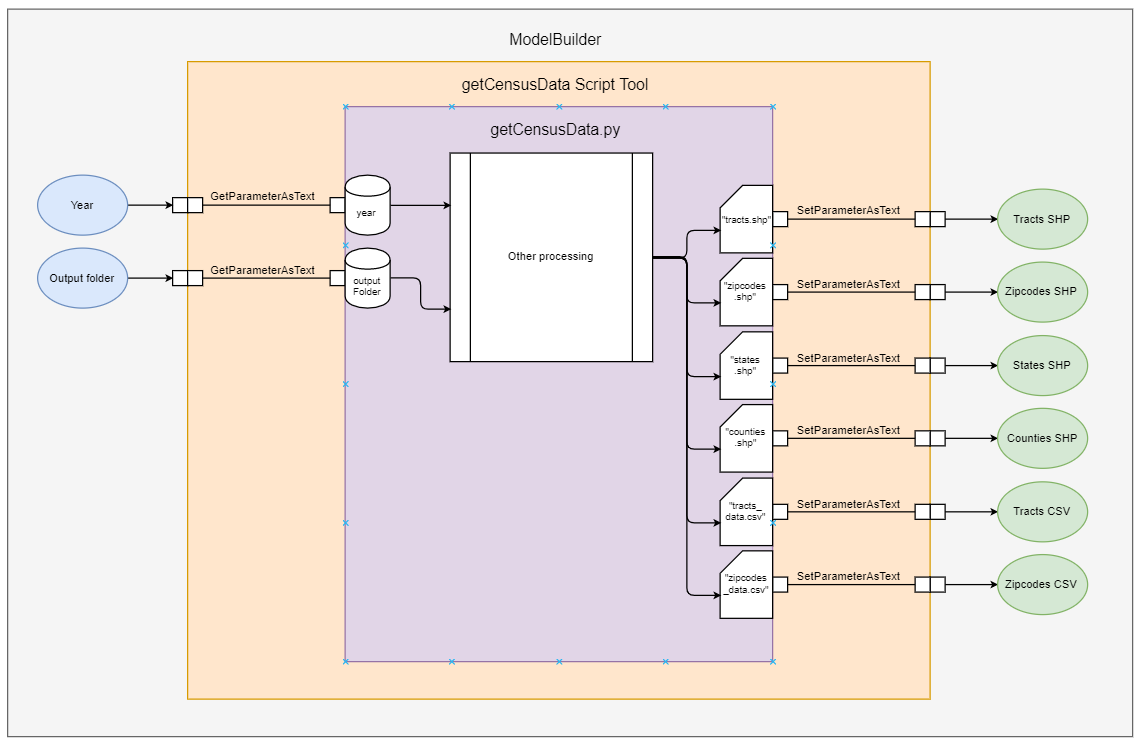

### Specify parameters

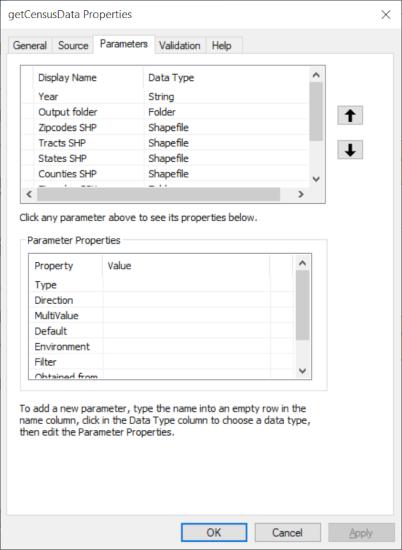

*Note: See [this document](https://desktop.arcgis.com/en/arcmap/latest/tools/supplement/pdf/Geoprocessing_data_types.pdf) for descriptions of the various data type options.*

### Add tool to model

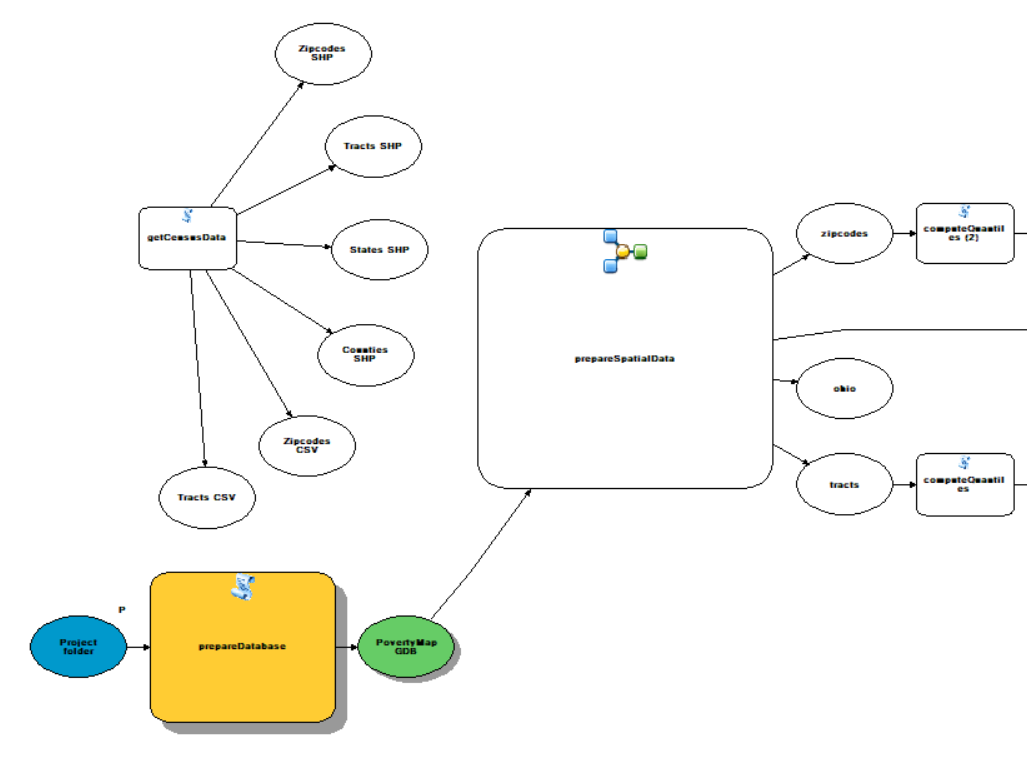

### Connect inputs and outputs

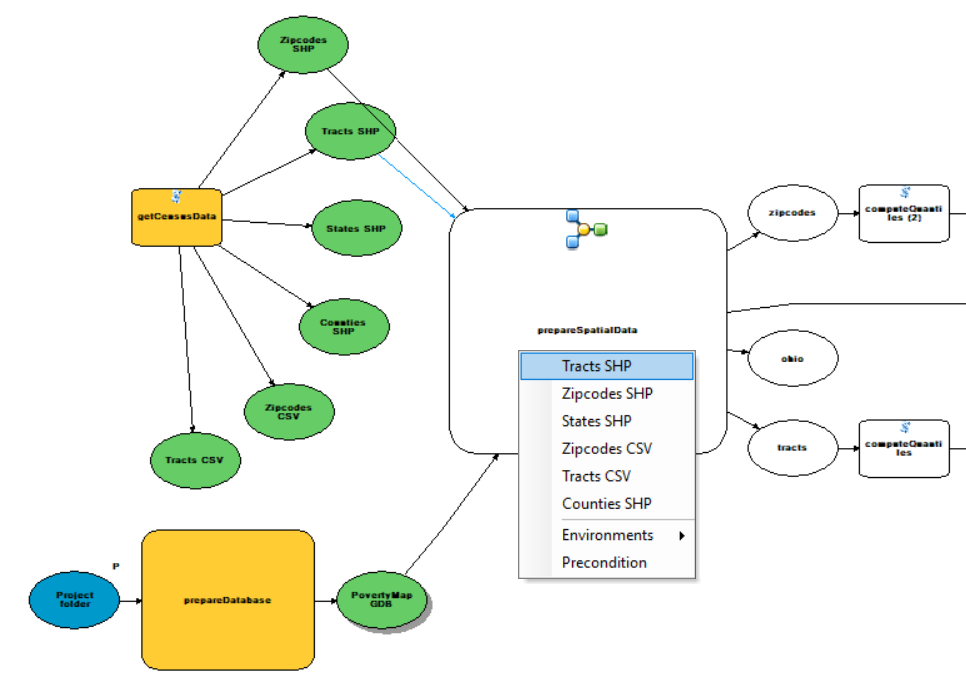

## Let's try it!

## Optional: Specify top-level model parameters

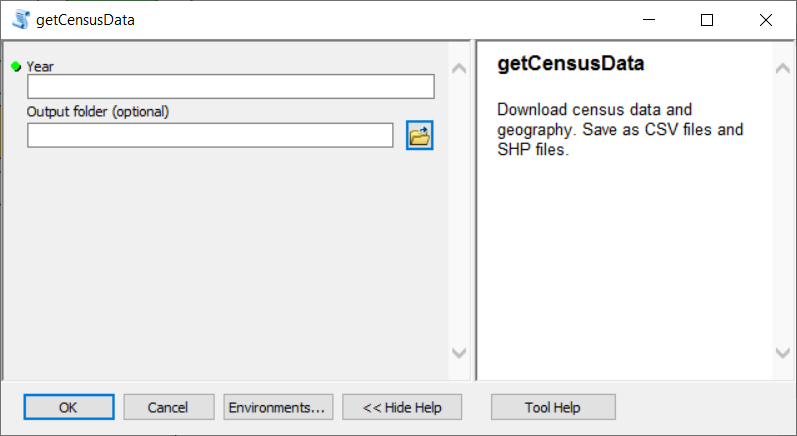

# Running the rest of the model

  1. prepareDatabase
  2. prepareSpatialData
  3. computeQuantiles
  4. buildMap
  5. overwriteService

## prepareDatabase (Python)

Purpose: Creates a file geodatabase to store the output data

## prepareSpatialData (ModelBuilder)

Purpose: Joins attributes to spatial data and prepares the geometry and attributes for proper display on a webmap.

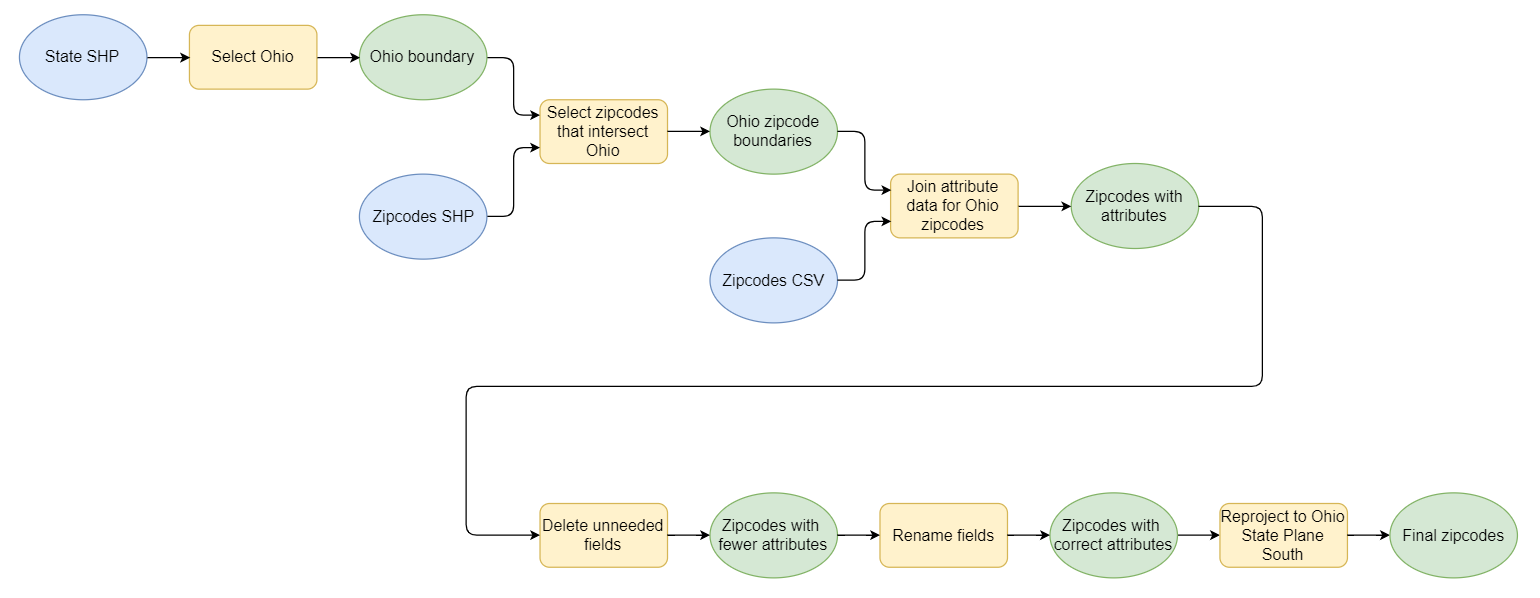

*Note: This diagram shows a simplified flow for the zipcodes layer.  The flow for the tracts layer is similar.  The model also prepares a layer for counties and one for the state as a whole.*

## computeQuantiles (Python)

Purpose: Classifies the tracts/zipcodes into a set of 21 quantiles (median, plus deciles above and deciles below the median)

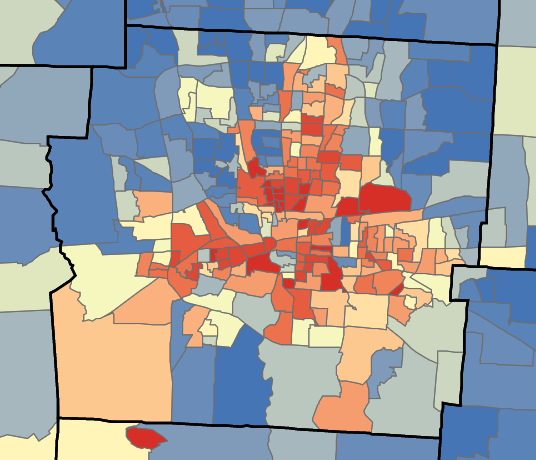

*Note: This is accomplished using [pandas](https://pandas.pydata.org/), an open source data science library for Python.  The class assignments are stored in the attribute table.  This allows for consistent analysis and visualization using a variety of platforms.*


## buildMap (Python)

Purpose: Prepares a complete ArcGIS Map document comprised of three layers (counties, zipcodes, and tracts), properly symbolized and including all required metadata.

*Note: The arcpy.mapping module is used to assemble the map.  This relies on an existing template map document and an existing layer file for each layer.*

## overwriteService (Python)

Purpose: Converts the map document to a service draft and publishes it as a hosted feature layer on ArcGIS Online.

*Note: For simplicity, this script overwrites an existing service called "OhioPovertyMap".  User must sign in to ArcGIS Online using the dialog in ArcMap File menu prior to executing this tool.*

# Check out the final product!

The [web map](http://arcg.is/1f4X9X), depicted below, is publicly available on ArcGIS Online.

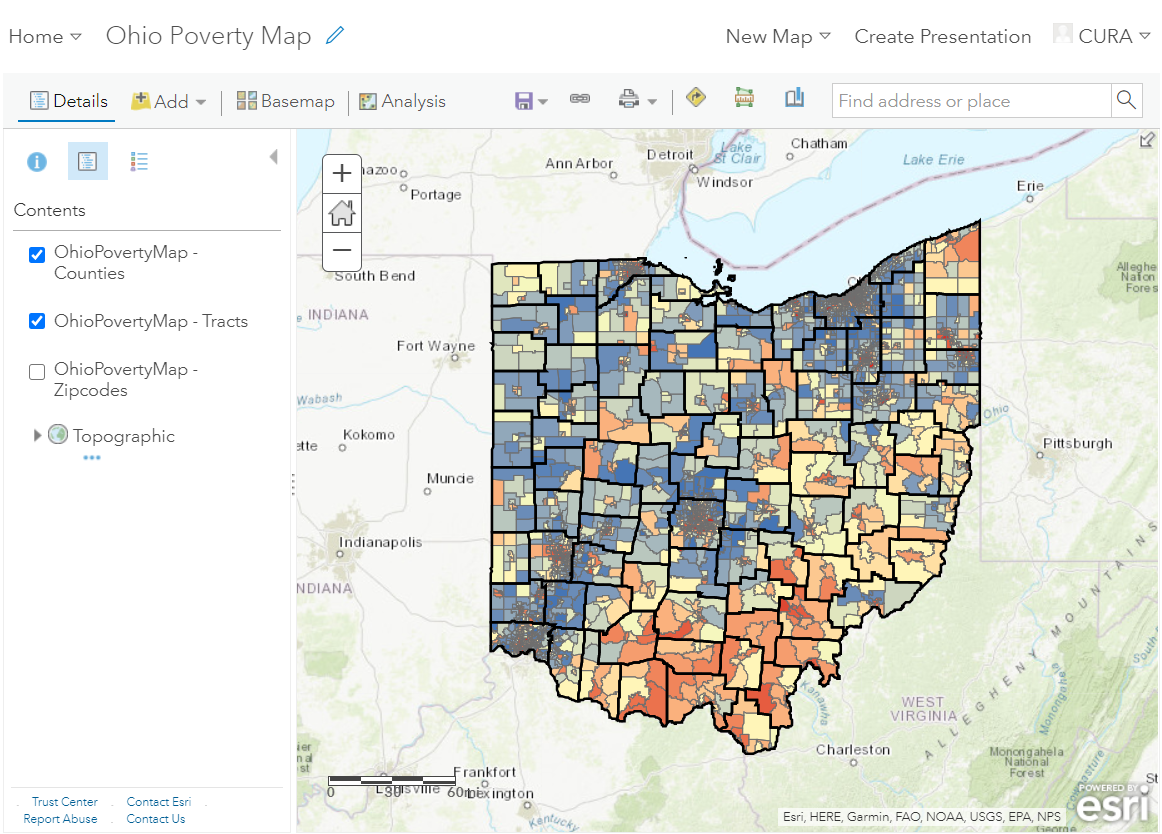

*Note: The web map itself was created manually via the ArcGIS Online web interface, but displays the layers published using the pipeline described herein.  Each time the pipeline is run, the published layers are overwritten and the changes are depicted on the map.*

# Thank you!

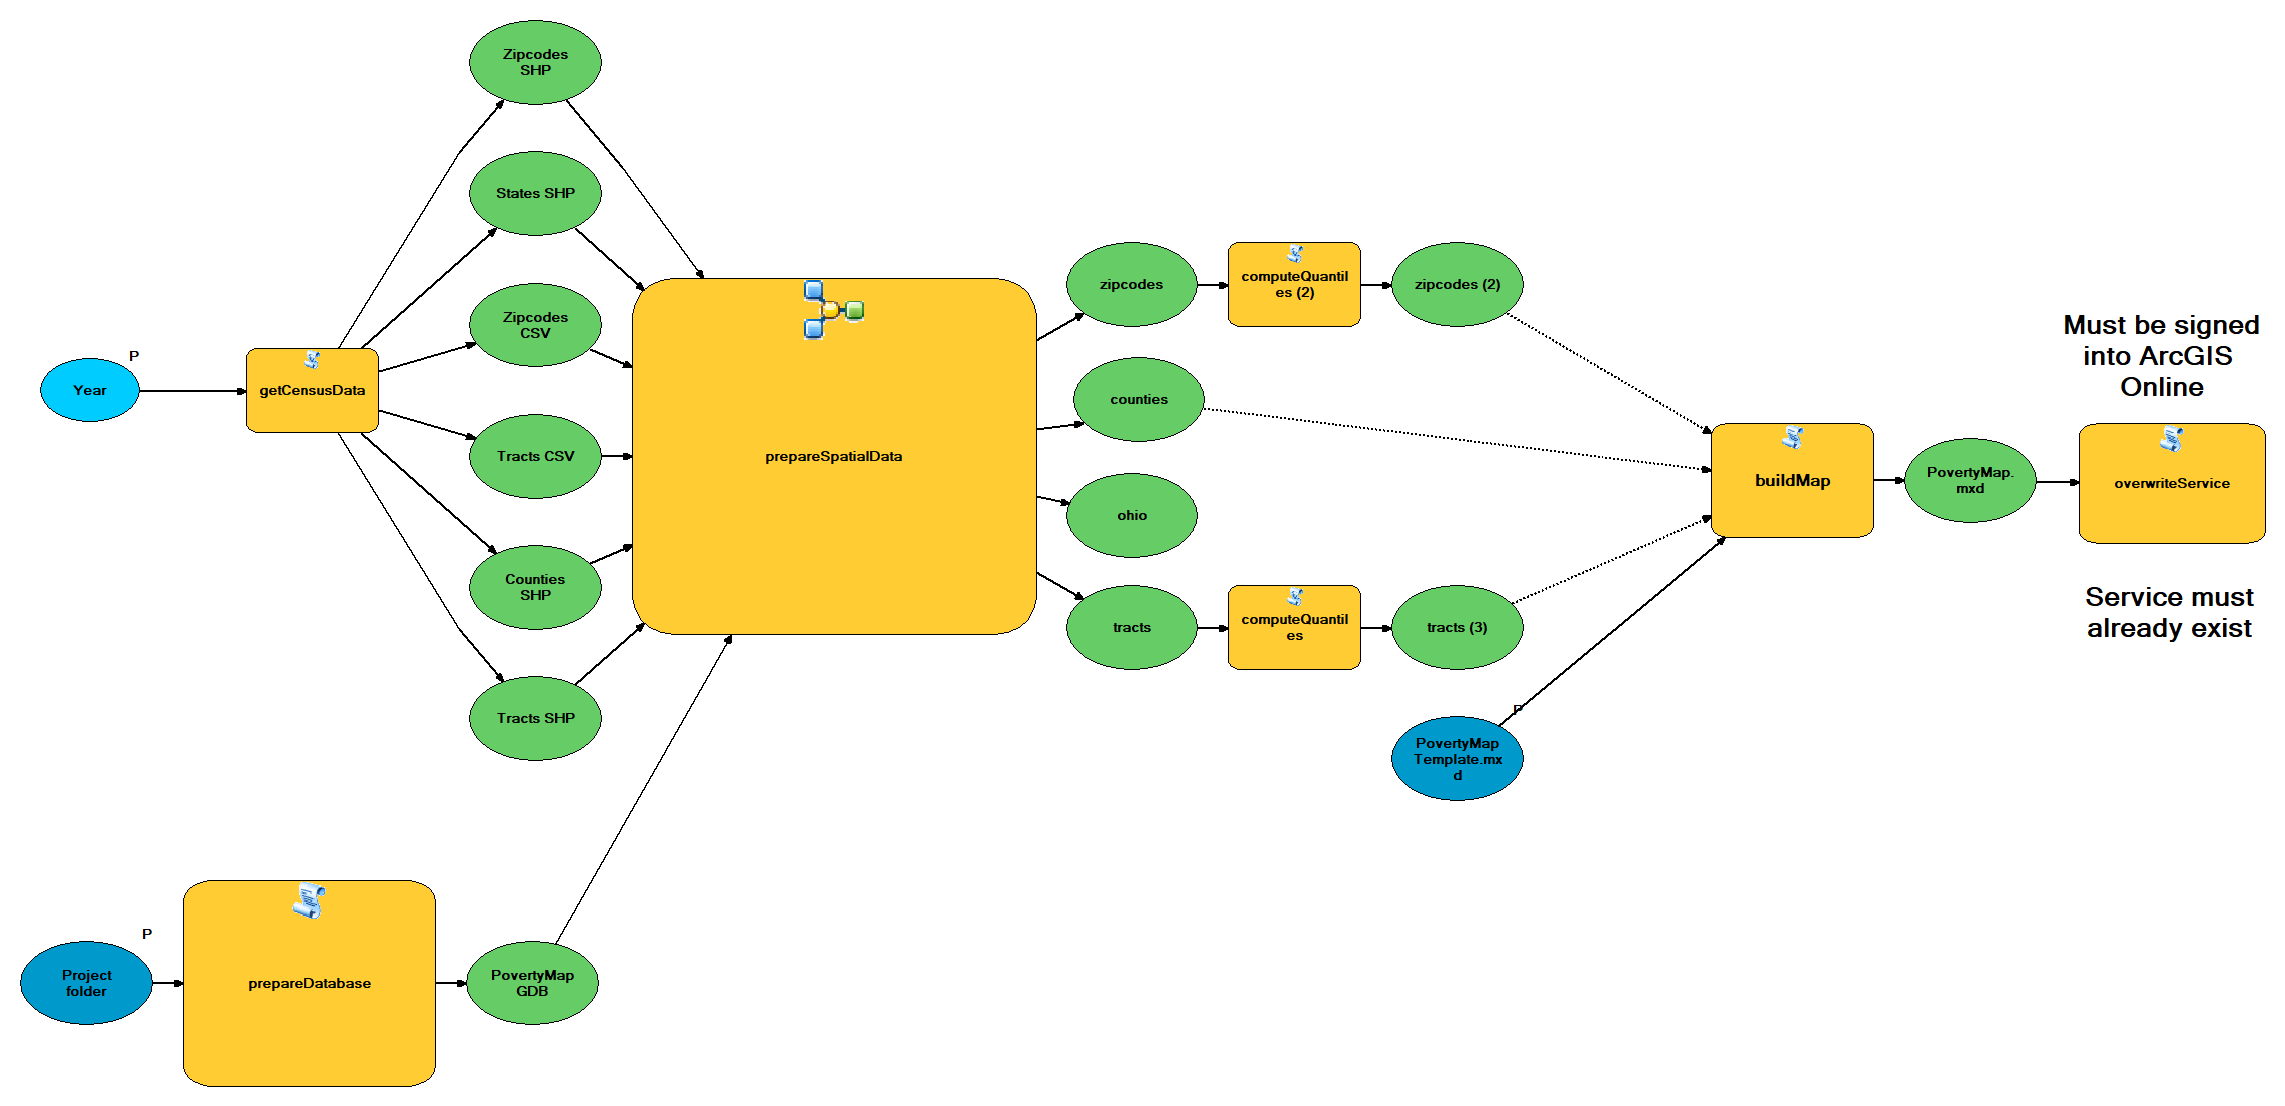

Questions?  Contact Adam Porr <porr.4@osu.edu>

# Appendix: Caveats

## After cloning from GitLab

  1. Verify output paths for "Project" tool instances in prepareSpatialData (I had some trouble with these changing, but it might have been a fluke.)
  2. Verify data sources listed in .lyr files (this should be fixed now)

## Before running PovertyMapFullWorkflow

  1. Enable overwrite output in geoprocessing options
  2. Verify the following input parameters and adjust if necessary:
    - Year
    - Project folder (especially this one)
    - Template MXD
  3. Log in to ArcGIS Online
  4. Create OhioPovertyMap (run the workflow prior to overwriteService, publish the service manually, then run overwriteService)  

## Miscellany

  1. This workflow has been tested on the following platform:
    - Windows 10
    - ArcGIS Desktop 10.7.1
    - Python 2.7.18 (included with ArcGIS Desktop)